In [1]:
import os
import pandas as pd
import numpy as np
import itertools

import tensorflow as tf
from tensorflow.keras import layers
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-darkgrid')
large = 22; med = 15; small = 13
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'axes.labelsize': small,
          'axes.titlesize': small,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
def read_file(fname):
    df = pd.read_csv(fname)
    print(df.shape)
    return df

In [3]:
u_bal = read_file('/Users/harrison/datasets/Purchase Redemption Data/user_balance_table.csv')
u_bal.head()

(2840421, 18)


,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,20140805,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,20140808,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
2,1,20140811,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,20140814,20403,20401,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,20140817,20409,20407,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN


In [4]:
all_data = u_bal.groupby('report_date').sum()[['total_purchase_amt','total_redeem_amt']]
all_data.index = pd.date_range(start='2013-07-01',end='2014-08-31')
all_data.columns = ['pur','red']
all_data.head()

,pur,red
2013-07-01,32488348,5525022
2013-07-02,29037390,2554548
2013-07-03,27270770,5953867
2013-07-04,18321185,6410729
2013-07-05,11648749,2763587


# 过滤数据

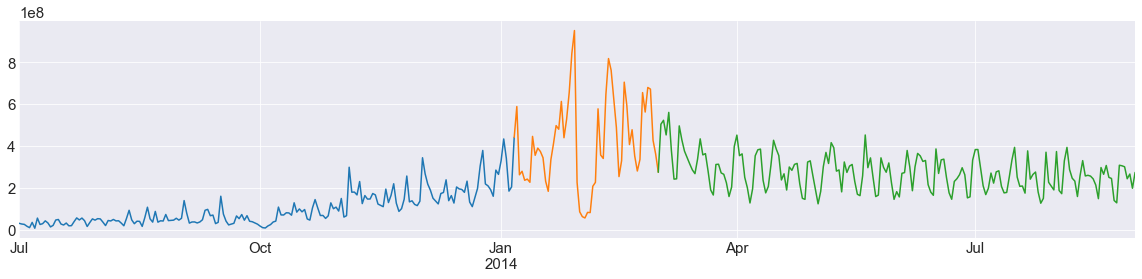

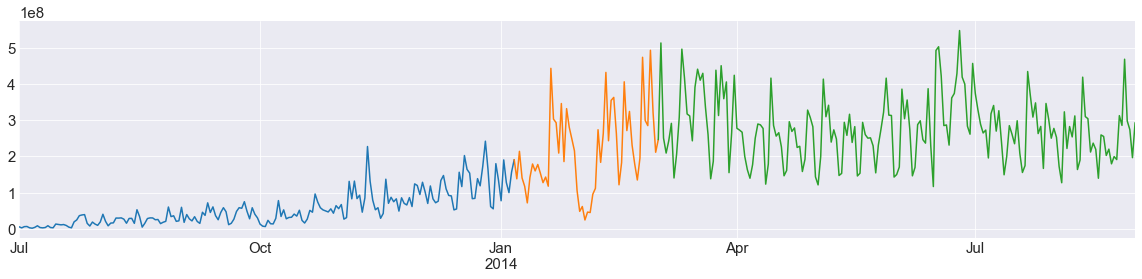

In [5]:
remove_s = '2014-01-06'
reomve_e = '2014-03-02'

adj_range = [all_data[:remove_s], all_data[remove_s:reomve_e], all_data[reomve_e:]]
for i in adj_range:
    i.pur.plot(figsize=(20,4))
plt.show()
for i in adj_range:
    i.red.plot(figsize=(20,4))

In [191]:
adj_data = pd.concat([all_data[:'2014-01-05'], all_data['2014-03-03':]], ignore_index=True)
adj_data.index = pd.date_range(periods=len(adj_data),end='2014-08-31')

# 评价函数

In [214]:
def AE(y, yhat):
    return np.abs(y - yhat) / np.abs(y)

def total_AE(purchasehat, redeemhat, purchase, redeem, h: int = 0.1):
    return sum(map(lambda x : np.exp(-x/h)*10, AE(purchase, purchasehat))) * 0.45 + sum(map(lambda x : np.exp(-x/h)*10, AE(redeem, redeemhat))) * 0.55

def pur_AE(pre_pur, pur, h: int = 0.08):
    return sum(map(lambda x : np.exp(-x/h)*10, AE(pur, pre_pur))) * 0.45

def red_AE(pre_red, red, h: int = 0.08):
    return sum(map(lambda x : np.exp(-x/h)*10, AE(red, pre_red))) * 0.55

# data transform

In [192]:
# LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(np.array(adj_data.pur).reshape(-1,1))

train = dataset[:-30]
real_y = dataset[-30:]

In [284]:
look_back = 20
def create_data_set(data_set):
    data_x, data_y = [], []
    for i in range(len(data_set)-look_back - 30):
        a = data_set[i:(i + look_back), 0]
        data_x.append(a)
        data_y.append(list(data_set[i + look_back: i + look_back + 30, 0]))
    # print(numpy.array(data_y).shape)
    return np.array(data_x), np.array(data_y), data_set[-look_back:, 0].reshape(1, 1, look_back)

In [285]:
train_x, train_y, test = create_data_set(train)

# data format

In [286]:
print(train_x.shape)
train_x[0]

(291, 20)


array([0.04255613, 0.03631373, 0.03311811, 0.01692931, 0.00485961,
       0.05026729, 0.        , 0.08736216, 0.03226463, 0.03931489,
       0.06351545, 0.0456232 , 0.01121961, 0.02469689, 0.07084753,
       0.07535943, 0.03627446, 0.02762585, 0.04471192, 0.02076034])

In [287]:
print(train_y.shape)
train_y[0]

(291, 30)


array([0.02203256, 0.05695588, 0.08895015, 0.07137927, 0.08767899,
       0.06468512, 0.01489117, 0.04937028, 0.08058572, 0.06967661,
       0.08249873, 0.08032865, 0.05264284, 0.0228527 , 0.0665364 ,
       0.06271413, 0.0757996 , 0.06321316, 0.0642721 , 0.04425077,
       0.02107912, 0.084217  , 0.15476541, 0.07191905, 0.0390339 ,
       0.0605236 , 0.0591892 , 0.01575232, 0.09178458, 0.18129043])

In [288]:
print(test.shape)
test

(1, 1, 20)


array([[[0.30895399, 0.44468874, 0.58942244, 0.69810072, 0.44145762,
         0.36177302, 0.36423026, 0.30296551, 0.66770859, 0.42350052,
         0.4639794 , 0.48493101, 0.31235687, 0.21581098, 0.25766541,
         0.65626585, 0.39638331, 0.36350535, 0.33060463, 0.66191317]]])

# model

In [289]:
# create and fit the LSTM network
batch_size = 12
epochs = 100

model = tf.keras.Sequential()
model.add(layers.LSTM(64, input_shape=(1,look_back), return_sequences=True))
model.add(layers.LSTM(32, return_sequences=False))
model.add(layers.Dense(30))
model.compile(loss='mean_squared_error', optimizer='adam')

# reshape input to be [samples, time steps, features]
model.fit(np.reshape(train_x,(train_x.shape[0], 1, train_x.shape[1])), train_y, epochs=epochs, batch_size=batch_size, verbose=1)

Train on 291 samples
Epoch 1/100
291/291 [==============================] - 7s 25ms/sample - loss: 0.1400
Epoch 2/100
291/291 [==============================] - 0s 662us/sample - loss: 0.0647
Epoch 3/100
291/291 [==============================] - 0s 660us/sample - loss: 0.0265
Epoch 4/100
291/291 [==============================] - 0s 658us/sample - loss: 0.0218
Epoch 5/100
291/291 [==============================] - 0s 665us/sample - loss: 0.0215
Epoch 6/100
291/291 [==============================] - 0s 661us/sample - loss: 0.0212
Epoch 7/100
291/291 [==============================] - 0s 664us/sample - loss: 0.0209
Epoch 8/100
291/291 [==============================] - 0s 672us/sample - loss: 0.0207
Epoch 9/100
291/291 [==============================] - 0s 666us/sample - loss: 0.0205
Epoch 10/100
291/291 [==============================] - 0s 716us/sample - loss: 0.0202
Epoch 11/100
291/291 [==============================] - 0s 672us/sample - loss: 0.0200
Epoch 12/100
291/291 [==========

In [290]:
model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (None, 1, 64)             21760     
_________________________________________________________________
lstm_52 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_38 (Dense)             (None, 30)                990       
Total params: 35,166
Trainable params: 35,166
Non-trainable params: 0
_________________________________________________________________


In [291]:
testPredict = model.predict(test)

#反归一化
testPredict_i = scaler.inverse_transform(testPredict).reshape(-1)
real_y_i = scaler.inverse_transform(real_y).reshape(-1)

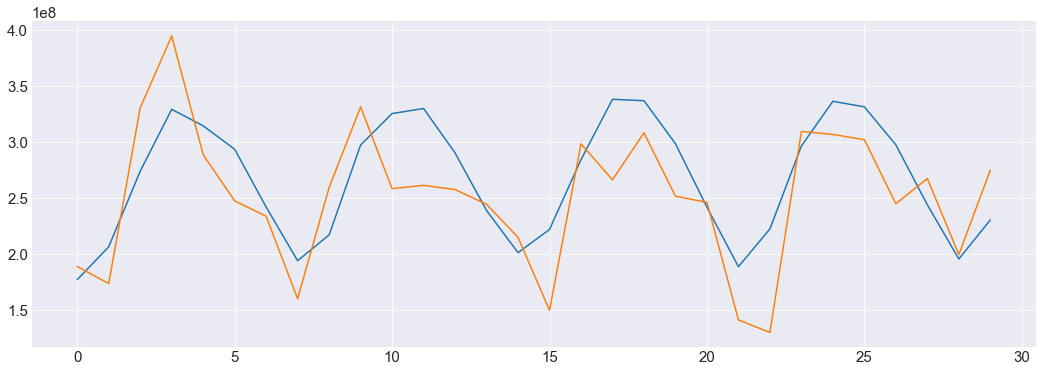

36.726999487082175

In [292]:
fig = plt.figure(figsize=(18,6))
plt.plot(testPredict_i)
plt.plot(real_y_i)
plt.show()

pur_AE(testPredict_i, real_y_i, h=0.08)